In [87]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Assignment 3 - Basic Predictions and Regression

## Questions

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul> 
<li> <b>defind some function and get some samples</b>
<li> <b>bulid a test model</b>
<li> <b> get the avg of each district</b>
<li> <b>purpwin(mean value), ci, and errors</b>
<li> <b> What do you think about the error/accuracy:</b> 
<li> <b>the errors are around 1.5% for each districts, so I can say there are low error and high accuracy.</b>
<li> <b>we can also estimation that purple party will win! because purple win the district 1,3,4,7 (4/7).</b>
</ul>

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [88]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns={"district"})

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head()

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53


##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [89]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns={"voter_turn_percentage"})
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head()

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017


## Start Your Work

### Part 1 - Election

<AxesSubplot:xlabel='voter_turn_percentage', ylabel='Yellow_improvement'>

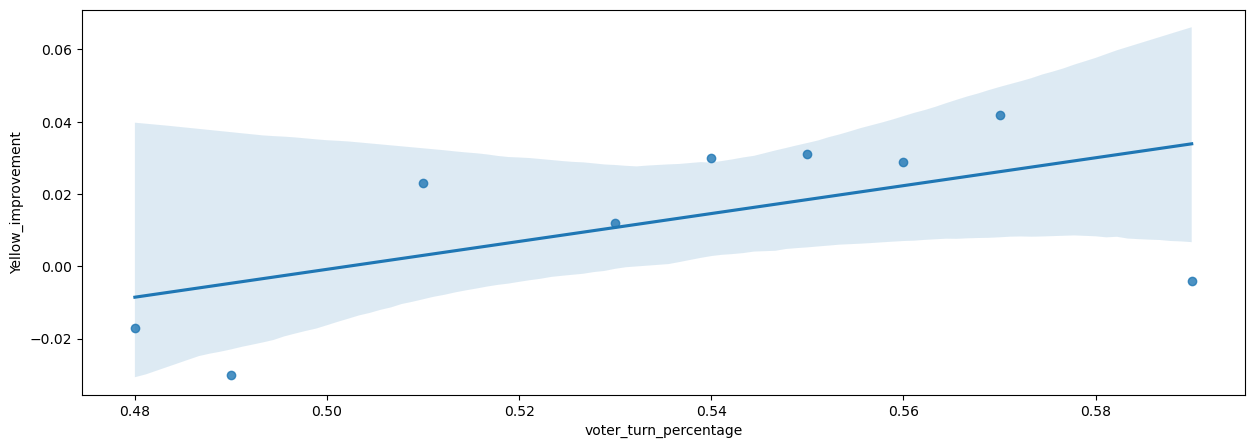

In [90]:
sns.regplot(x=past_vote_table["voter_turn_percentage"], y=past_vote_table["Yellow_improvement"])

In [91]:
# Do some stuff 
def oneVote(probCalc):
    vote = np.random.binomial(n=1, p=probCalc)
    return vote

def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(voteProb))
    return vote_list

def getSamples2(voteProb, n=1000, samples=100, ciLow=2.5, ciHi=97.5):
    meanList = []
    for i in range(samples):
        meanList.append(np.mean(getSample(voteProb, n)))
    muList = [voteProb] * samples
    cdf = thinkstats2.Cdf(meanList) 
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci

def simulate(probValue):
    means, err, cdfFin, ciFin = getSamples2(probValue, n=1000, samples=100, ciLow=2.5, ciHi=97.5)
    purpw = 0 
    for i in range(100):
        if means[i] > .5000:
            purpw = purpw + 1
    return (purpw/100), err, cdfFin, ciFin

In [92]:
y = np.array(past_vote_table['Yellow_improvement']).reshape(-1,1)
x = np.array(past_vote_table['voter_turn_percentage']).reshape(-1,1)
xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=0.2,random_state=42)

model = LinearRegression().fit(xTrain,yTrain)
yell_pred= model.predict(np.array(0.60).reshape(1,-1))
rSq = model.score(xTest, yTest)
print(yell_pred[0][0], rSq)

0.032054140127388525 -4.928570902788179


In [93]:
dist_polls['vote_avg']=round((dist_polls['Poll_1']+dist_polls['Poll_2']+dist_polls['Poll_3']+dist_polls['Poll_4']+dist_polls['Poll_5']+dist_polls['Poll_6']+dist_polls['Poll_7']+dist_polls['Poll_8']+dist_polls['Poll_9'])/9,2)
dist_polls


,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9,vote_avg
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57,0.54
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39,0.48
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52,0.51
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57,0.60
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53,0.45
5,6,0.46,0.48,0.46,0.45,0.51,0.52,0.46,0.49,0.43,0.47
6,7,0.54,0.53,0.52,0.51,0.53,0.52,0.56,0.55,0.53,0.53


In [94]:
# Do some stuff
purpwin = []
ciFin = []
errors = []

dis1=simulate(dist_polls["vote_avg"].iloc[0])
dis2=simulate(dist_polls["vote_avg"].iloc[1])
dis3=simulate(dist_polls["vote_avg"].iloc[2])
dis4=simulate(dist_polls["vote_avg"].iloc[3])
dis5=simulate(dist_polls["vote_avg"].iloc[4])
dis6=simulate(dist_polls["vote_avg"].iloc[5])
dis7=simulate(dist_polls["vote_avg"].iloc[6])

purpwin.append(dis1[0])
ciFin.append(dis1[3][0])
ciFin.append(dis1[3][1])
errors.append(dis1[1])
purpwin.append(dis2[0])
ciFin.append(dis2[3][0])
ciFin.append(dis2[3][1])
errors.append(dis2[1])
purpwin.append(dis3[0])
ciFin.append(dis3[3][0])
ciFin.append(dis3[3][1])
errors.append(dis3[1])
purpwin.append(dis4[0])
ciFin.append(dis4[3][0])
ciFin.append(dis4[3][1])
errors.append(dis4[1])
purpwin.append(dis5[0])
ciFin.append(dis5[3][0])
ciFin.append(dis5[3][1])
errors.append(dis5[1])
purpwin.append(dis6[0])
ciFin.append(dis6[3][0])
ciFin.append(dis6[3][1])
errors.append(dis6[1])
purpwin.append(dis7[0])
ciFin.append(dis7[3][0])
ciFin.append(dis7[3][1])
errors.append(dis7[1])


In [95]:
print("district 1 : percent of purple wins: "+str(round(dis1[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis1[3][0]*100,2))+'% and '+str(round(dis1[3][1]*100,2))+'% of votes.')
print("Error of district 1: "+str(dis1[1]))
print("district 2 : percent of purple wins: "+str(round(dis2[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis2[3][0]*100,2))+'% and '+str(round(dis2[3][1]*100,2))+'% of votes.')
print("Error of district 2: "+str(dis2[1]))
print("district 3 : percent of purple wins: "+str(round(dis3[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis3[3][0]*100,2))+'% and '+str(round(dis3[3][1]*100,2))+'% of votes.')
print("Error of district 3: "+str(dis3[1]))
print("district 4 : percent of purple wins: "+str(round(dis4[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis4[3][0]*100,2))+'% and '+str(round(dis4[3][1]*100,2))+'% of votes.')
print("Error of district 4: "+str(dis4[1]))
print("district 5 : percent of purple wins: "+str(round(dis5[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis5[3][0]*100,2))+'% and '+str(round(dis5[3][1]*100,2))+'% of votes.')
print("Error of district 5: "+str(dis5[1]))
print("district 6 : percent of purple wins: "+str(round(dis6[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis6[3][0]*100,2))+'% and '+str(round(dis6[3][1]*100,2))+'% of votes.')
print("Error of district 6: "+str(dis6[1]))
print("district 7 : percent of purple wins: "+str(round(dis7[0]*100,2))+'% and we are 95% confidence that purple gets'+str(round(dis7[3][0]*100,2))+'% and '+str(round(dis7[3][1]*100,2))+'% of votes.')
print("Error of district 7: "+str(dis7[1]))

district 1 : percent of purple wins: 100.0% and we are 95% confidence that purple gets51.2% and 57.4% of votes.
Error of district 1: 0.0166057219054156
district 2 : percent of purple wins: 7.0% and we are 95% confidence that purple gets45.0% and 50.3% of votes.
Error of district 2: 0.014934188963582852
district 3 : percent of purple wins: 73.0% and we are 95% confidence that purple gets47.4% and 53.9% of votes.
Error of district 3: 0.016763949415337678
district 4 : percent of purple wins: 100.0% and we are 95% confidence that purple gets57.3% and 63.0% of votes.
Error of district 4: 0.015098013114314092
district 5 : percent of purple wins: 0.0% and we are 95% confidence that purple gets41.4% and 48.3% of votes.
Error of district 5: 0.017542804792848837
district 6 : percent of purple wins: 6.0% and we are 95% confidence that purple gets44.1% and 50.7% of votes.
Error of district 6: 0.01714205355259398
district 7 : percent of purple wins: 98.0% and we are 95% confidence that purple gets5

### Part 2 - Regression

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>
<li>
<li>
</ul>

In [96]:
df = pd.read_csv("players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22
